In [243]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from mpl_toolkits import mplot3d

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrices
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.discrete.discrete_model import Logit

%matplotlib inline

In [97]:
def diagnostic_plots(mod):
    sns.set_style('darkgrid')
    f, ax = plt.subplots(2,2, figsize=(12,10))
    
    smoothed = lowess(mod.resid, mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=mod.resid, ax=ax[0,0], alpha=0.5)
    ax[0,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[0,0].axhline(y=0, color='grey', ls='dashed', alpha=0.5)
    ax[0,0].set_xlabel('Fitted Values')
    ax[0,0].set_ylabel('Residuals')
    ax[0,0].set_title('Residuals vs Fitted')

    sm.qqplot(mod.resid, ax=ax[0,1], fit=True, line='45', alpha=0.5)
    ax[0,1].set_title('Normal Q-Q')
    
    student_residuals = mod.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = mod.resid.index
    smoothed = lowess(sqrt_student_residuals,mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=sqrt_student_residuals, ax=ax[1,0], alpha=0.5)
    ax[1,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,0].set_xlabel('Fitted values')
    ax[1,0].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax[1,0].set_title('Scale-Location')
    
    smoothed = lowess(mod.get_influence().resid_studentized_internal, mod.get_influence().hat_matrix_diag)
    
    sns.scatterplot(x=mod.get_influence().hat_matrix_diag, y=mod.get_influence().resid_studentized_internal, ax=ax[1,1], alpha=0.5)
    ax[1,1].axhline(y=0, color='grey', linestyle='dashed', alpha=0.5)
    ax[1,1].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,1].set_xlabel('Leverage')
    ax[1,1].set_ylabel('Studentized Residuals')
    ax[1,1].set_title('Residuals vs Leverage')

## Chapter 4
### Lab
#### The Stock Market Data

In [98]:
stock = pd.read_csv('Smarket.csv')
stock.drop('Unnamed: 0', axis=1, inplace=True)

In [99]:
stock.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [100]:
stock.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [101]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 88.0+ KB


In [102]:
stock.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


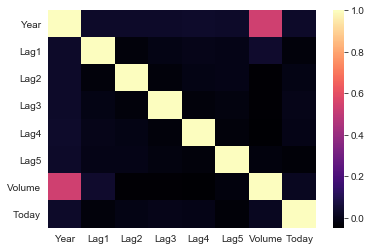

In [103]:
sns.heatmap(stock.corr(), cmap='magma')

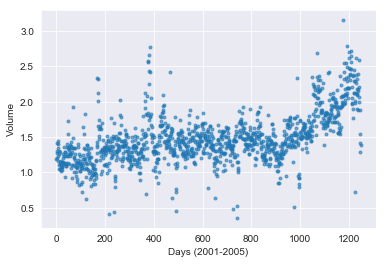

In [104]:
sns.set_style('darkgrid')
stock['Volume'].plot(marker='.', ls='none', alpha=0.6, ylabel='Volume', xlabel='Days (2001-2005)')

#### Logisitic Regression

In [105]:
def direction(df):
    if df['Direction'] == 'Up':
        return 1
    else: 
        return 0
stock['Target'] = stock.apply(direction, axis=1)
stock.head() # Can also use pd.get_dummies to replace the Direction column with Direction_Up column that is the same as the Target column 

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Target
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


In [106]:
X = stock.drop(['Direction', 'Year', 'Today', 'Target'], axis=1)
y = stock['Target']

In [107]:
log = LogisticRegression()
log.fit(X, y) # With sklearn

LogisticRegression()

In [108]:
print(log.coef_, log.intercept_)

[[-0.07284345 -0.04223481  0.0110163   0.00928427  0.01026372  0.13211221]] [-0.12108463]


In [109]:
#y, X = dmatrices('Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', data=stock, return_type='dataframe')
X_tr = sm.add_constant(X)
logmod = sm.Logit(y, X_tr).fit()
logmod.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                0.002074
Time:                        13:40:44   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [110]:
pred = logmod.predict(X_tr)

In [111]:
pred[0:11] # Probability the marker goes Up since the dummy variable created took Up as 1 

0     0.507084
1     0.481468
2     0.481139
3     0.515222
4     0.510781
5     0.506956
6     0.492651
7     0.509229
8     0.517614
9     0.488838
10    0.496521
dtype: float64

In [112]:
def label(series):
    if series > 0.5:
        return 'Up'
    else:
        return 'Down'
direction_pred = pred.apply(label)

In [113]:
pd.DataFrame(confusion_matrix(direction_pred, stock['Direction']), index=['Down', 'Up'], columns=['Down', 'Up'])

,Down,Up
Down,145,141
Up,457,507


In [114]:
np.mean(direction_pred == stock['Direction'])

0.5216

In [115]:
X = stock.drop(['Direction', 'Year', 'Today', 'Target'], axis=1)
y = stock['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [116]:
logmod = sm.Logit(y_train, sm.add_constant(X_train)).fit()
logmod.summary()

Optimization terminated successfully.
         Current function value: 0.685827
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                  750
Model:                          Logit   Df Residuals:                      743
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                0.005330
Time:                        13:40:44   Log-Likelihood:                -514.37
converged:                       True   LL-Null:                       -517.13
Covariance Type:            nonrobust   LLR p-value:                    0.4800
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2247      0.326     -0.689      0.491      -0.864       0.415
Lag1          -0.0838      0.067     -1.258      0.208      -0.214       0.047
Lag2           0.0143      0.066      0.215      0.830      -0.116       0.145
Lag3           0.0213      0.066      0.325      0.745      -0.107       0.150
Lag4           0.0817      0.066      1.246      0.213      -0.047       0.210
Lag5           0.0682      0.066      1.033      0.302      -0.061       0.197
Volume         0.2663      0.216      1.234      0.217      -0.157       0.689
==============================================================================
"""

In [117]:
pred = logmod.predict(sm.add_constant(X_test))

In [118]:
def label(series):
    if series > 0.5:
        return 1
    else:
        return 0
y_pred = pred.apply(label)

In [119]:
pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Down', 'Up'], columns=['Down', 'Up'])

,Down,Up
Down,38,42
Up,221,199


In [120]:
np.mean(y_pred == y_test) # Underwhelming performance, now we will remove predictors we think might not be helpful in predicting direction

0.474

In [121]:
X = stock[['Lag1', 'Lag2']]
y = stock['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [122]:
logmod = sm.Logit(y_train, sm.add_constant(X_train)).fit()
logmod.summary()

Optimization terminated successfully.
         Current function value: 0.688393
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                  750
Model:                          Logit   Df Residuals:                      747
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                0.001608
Time:                        13:40:44   Log-Likelihood:                -516.29
converged:                       True   LL-Null:                       -517.13
Covariance Type:            nonrobust   LLR p-value:                    0.4353
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1745      0.073      2.374      0.018       0.030       0.318
Lag1          -0.0832      0.066     -1.263      0.207      -0.212       0.046
Lag2           0.0164      0.066      0.248      0.804      -0.113       0.146
==============================================================================
"""

In [123]:
pred = logmod.predict(sm.add_constant(X_test))
def label(series):
    if series > 0.5:
        return 1
    else:
        return 0
y_pred = pred.apply(label)

In [124]:
pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])

,Pred Down,Pred Up
Actual Down,7,9
Actual Up,252,232


In [125]:
np.mean(y_pred == y_test)

0.478

In [126]:
train = stock[stock['Year'] < 2005]
test = stock[stock['Year'] == 2005]

In [127]:
X_train, X_test = train[['Lag1', 'Lag2']], test[['Lag1', 'Lag2']]
y_train, y_test = train['Target'], test['Target']

In [128]:
logmod = sm.Logit(y_train, sm.add_constant(X_train)).fit()
logmod.summary()

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                  998
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                0.001347
Time:                        13:40:44   Log-Likelihood:                -690.70
converged:                       True   LL-Null:                       -691.63
Covariance Type:            nonrobust   LLR p-value:                    0.3939
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.063      0.508      0.611      -0.092       0.156
Lag1          -0.0556      0.052     -1.076      0.282      -0.157       0.046
Lag2          -0.0445      0.052     -0.861      0.389      -0.146       0.057
==============================================================================
"""

In [129]:
pred = logmod.predict(sm.add_constant(X_test))
def label(series):
    if series > 0.5:
        return 1
    else:
        return 0
y_pred = pred.apply(label)

In [130]:
pd.DataFrame(confusion_matrix(y_pred, y_test),['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])

,Pred Down,Pred Up
Actual Down,35,35
Actual Up,76,106


In [131]:
np.mean(y_pred == y_test)

0.5595238095238095

#### Linear Discriminant Analysis

In [132]:
X_train, X_test = train[['Lag1', 'Lag2']], test[['Lag1', 'Lag2']]
y_train, y_test = train['Target'], test['Target']
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [133]:
lda.priors_ # Down, Up

array([0.49198397, 0.50801603])

In [134]:
lda_mean = pd.DataFrame(lda.means_, index=['Down', 'Up'], columns=['Lag1', 'Lag2'])
lda_mean

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


In [135]:
lda_scalings = pd.DataFrame(lda.scalings_, index=['Lag1', 'Lag2'], columns=['LD1']) # Corresponds to the coefficients in ISLR
lda_scalings

,LD1
Lag1,-0.642019
Lag2,-0.513529


In [136]:
lda_pred = lda.predict(X_test)

In [137]:
lda_cfm = pd.DataFrame(confusion_matrix(lda_pred, y_test),index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
lda_cfm

,Pred Down,Pred Up
Actual Down,35,35
Actual Up,76,106


In [138]:
np.mean(lda_pred == y_test)

0.5595238095238095

In [139]:
logprob = lda.predict_proba(X_test)

In [140]:
np.unique(logprob[:,1] > 0.5, return_counts=True)

(array([False,  True]), array([ 70, 182], dtype=int64))

In [141]:
logprob[0:21, 1]

array([0.50982075, 0.5207815 , 0.53318152, 0.52599893, 0.50721234,
       0.50614385, 0.50489844, 0.5127139 , 0.50929865, 0.51559738,
       0.50930372, 0.48800115, 0.51048477, 0.52932388, 0.52554071,
       0.52004166, 0.50642247, 0.49691062, 0.50211939, 0.51136691,
       0.49934319])

In [142]:
lda_pred[0:21]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
      dtype=int64)

In [143]:
np.sum(logprob[:,1] > 0.9)

0

#### Quadratic Discrimiant Analysis

In [144]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
 9   Target     1250 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 97.8+ KB


In [145]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [146]:
qda.priors_ # Down, Up

array([0.49198397, 0.50801603])

In [147]:
qda_means = pd.DataFrame(qda.means_, index=['Down', 'Up'], columns=['Lag1', 'Lag2'])
qda_means

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


In [148]:
qda_pred = qda.predict(X_test)

In [149]:
lda_cfm = pd.DataFrame(confusion_matrix(qda_pred, y_test),['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
lda_cfm

,Pred Down,Pred Up
Actual Down,30,20
Actual Up,81,121


In [150]:
np.mean(qda_pred == y_test) # QDA seems to perform better than LDA on this data

0.5992063492063492

#### K-Nearest Neighbors 

In [151]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [152]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), ['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
knn_cfm

,Pred Down,Pred Up
Actual Down,43,58
Actual Up,68,83


In [153]:
np.mean(y_pred == y_test) # With a 50% error rate K=1 does not result with a good prediction 

0.5

In [154]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) # We create a new model but this time we set K=3

KNeighborsClassifier(n_neighbors=3)

In [155]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
knn_cfm

,Pred Down,Pred Up
Actual Down,48,55
Actual Up,63,86


In [156]:
np.mean(y_pred == y_test) # The error rate decreases but not significantally, QDA performs best on this data

0.5317460317460317

#### An Application to Caravan Insurance Data

In [157]:
caravan = pd.read_csv('Caravan.csv')
caravan.drop('Unnamed: 0', axis=1, inplace=True)

In [158]:
caravan['Purchase'].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [159]:
standardized_X = pd.DataFrame(scale(caravan.drop('Purchase', axis=1)), index=caravan.drop('Purchase', axis=1).index, 
                              columns=caravan.drop('Purchase', axis=1).columns)

In [160]:
caravan = pd.get_dummies(caravan, drop_first=True)

In [161]:
X_train, X_test = standardized_X.iloc[1001:], standardized_X.iloc[0:1001]
y_train, y_test = caravan.iloc[1001:]['Purchase_Yes'], caravan.iloc[0:1001]['Purchase_Yes']
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [162]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual No', 'Actual Yes'], columns=['Pred No', 'Pred Yes'])
knn_cfm

,Pred No,Pred Yes
Actual No,874,50
Actual Yes,68,9


In [163]:
9/(68+9)

0.11688311688311688

In [164]:
np.mean(y_pred != y_test) # The error rate is low at 12% which looks good at first 

0.11788211788211789

In [165]:
np.mean(1 == y_test) # Since 1 = 'Yes' this means that if you predicted 'No' for every value you could get the error rate down to 6%
# Comparing this to the 11% we highlighted from the confusion matrix, 11% is double the rate one would get from randomly guessing. 

0.058941058941058944

In [166]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [167]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual No', 'Actual Yes'], columns=['Pred No', 'Pred Yes'])
knn_cfm

,Pred No,Pred Yes
Actual No,922,54
Actual Yes,20,5


In [168]:
5/25

0.2

In [169]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [170]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual No', 'Actual Yes'], columns=['Pred No', 'Pred Yes'])
knn_cfm

,Pred No,Pred Yes
Actual No,932,55
Actual Yes,10,4


In [171]:
4/14

0.2857142857142857

In [172]:
log = LogisticRegression()
log.fit(X_train, y_train)

C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [173]:
y_pred = log.predict(X_test)
log_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['No', 'Yes'], columns=['No', 'Yes'])
log_cfm

,No,Yes
No,935,59
Yes,7,0


In [174]:
y_pred_new = (log.predict_proba(X_test)[:,1] >= 0.25).astype(int) # Change the probability threshhold to 0.25 

In [175]:
log_cfm = pd.DataFrame(confusion_matrix(y_pred_new, y_test), index=['Actual No', 'Actual Yes'], columns=['Pred No', 'Pred Yes'])
log_cfm

,Pred No,Pred Yes
Actual No,918,48
Actual Yes,24,11


In [176]:
11/(24+11) # We predict that 35 will purchase insurance and are correct for 31% of people, this is 5 times better than random guessing (6%)

0.3142857142857143

### Applied Exercises
#### 10)
#### a)

In [177]:
weekly = pd.read_csv('Weekly.csv')

In [178]:
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


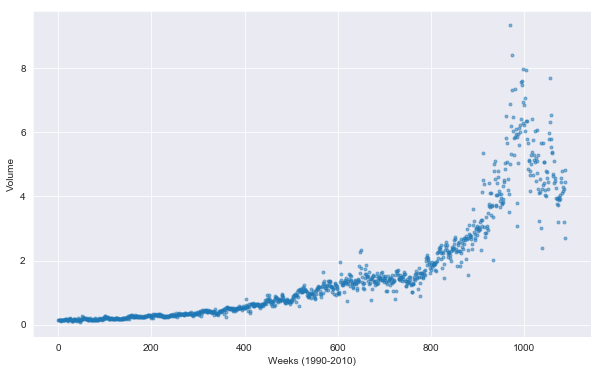

In [179]:
plt.figure(figsize=(10,6))
fig = weekly['Volume'].plot(marker='.', ls='none', alpha=0.5, ylabel='Volume', xlabel='Weeks (1990-2010)')
# Volume grows with time but then dips and decreases from the 1000th and onward

In [180]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


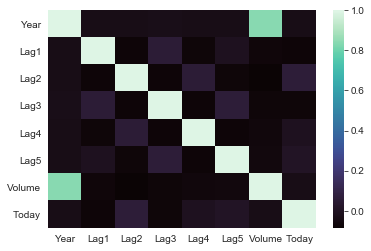

In [181]:
sns.heatmap(weekly.corr(), cmap='mako')
# There does not seem to be a correlation between the predictors other than Volume and Year

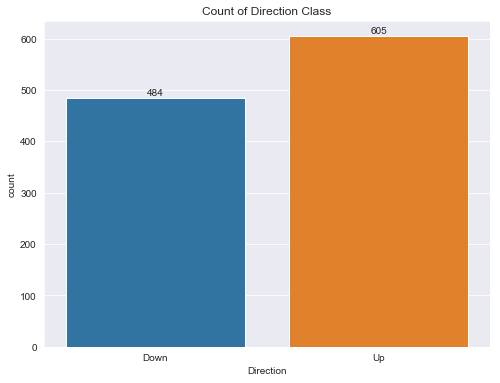

In [193]:
f, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='Direction', data=weekly, ax=ax)
ax.set_title('Count of Direction Class')
i=1
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 5,
        weekly['Direction'].value_counts()[i],ha="center")
    i -= 1
    
# The Direction class is well spread between 'Up' and 'Down' which makes modeling with it easier

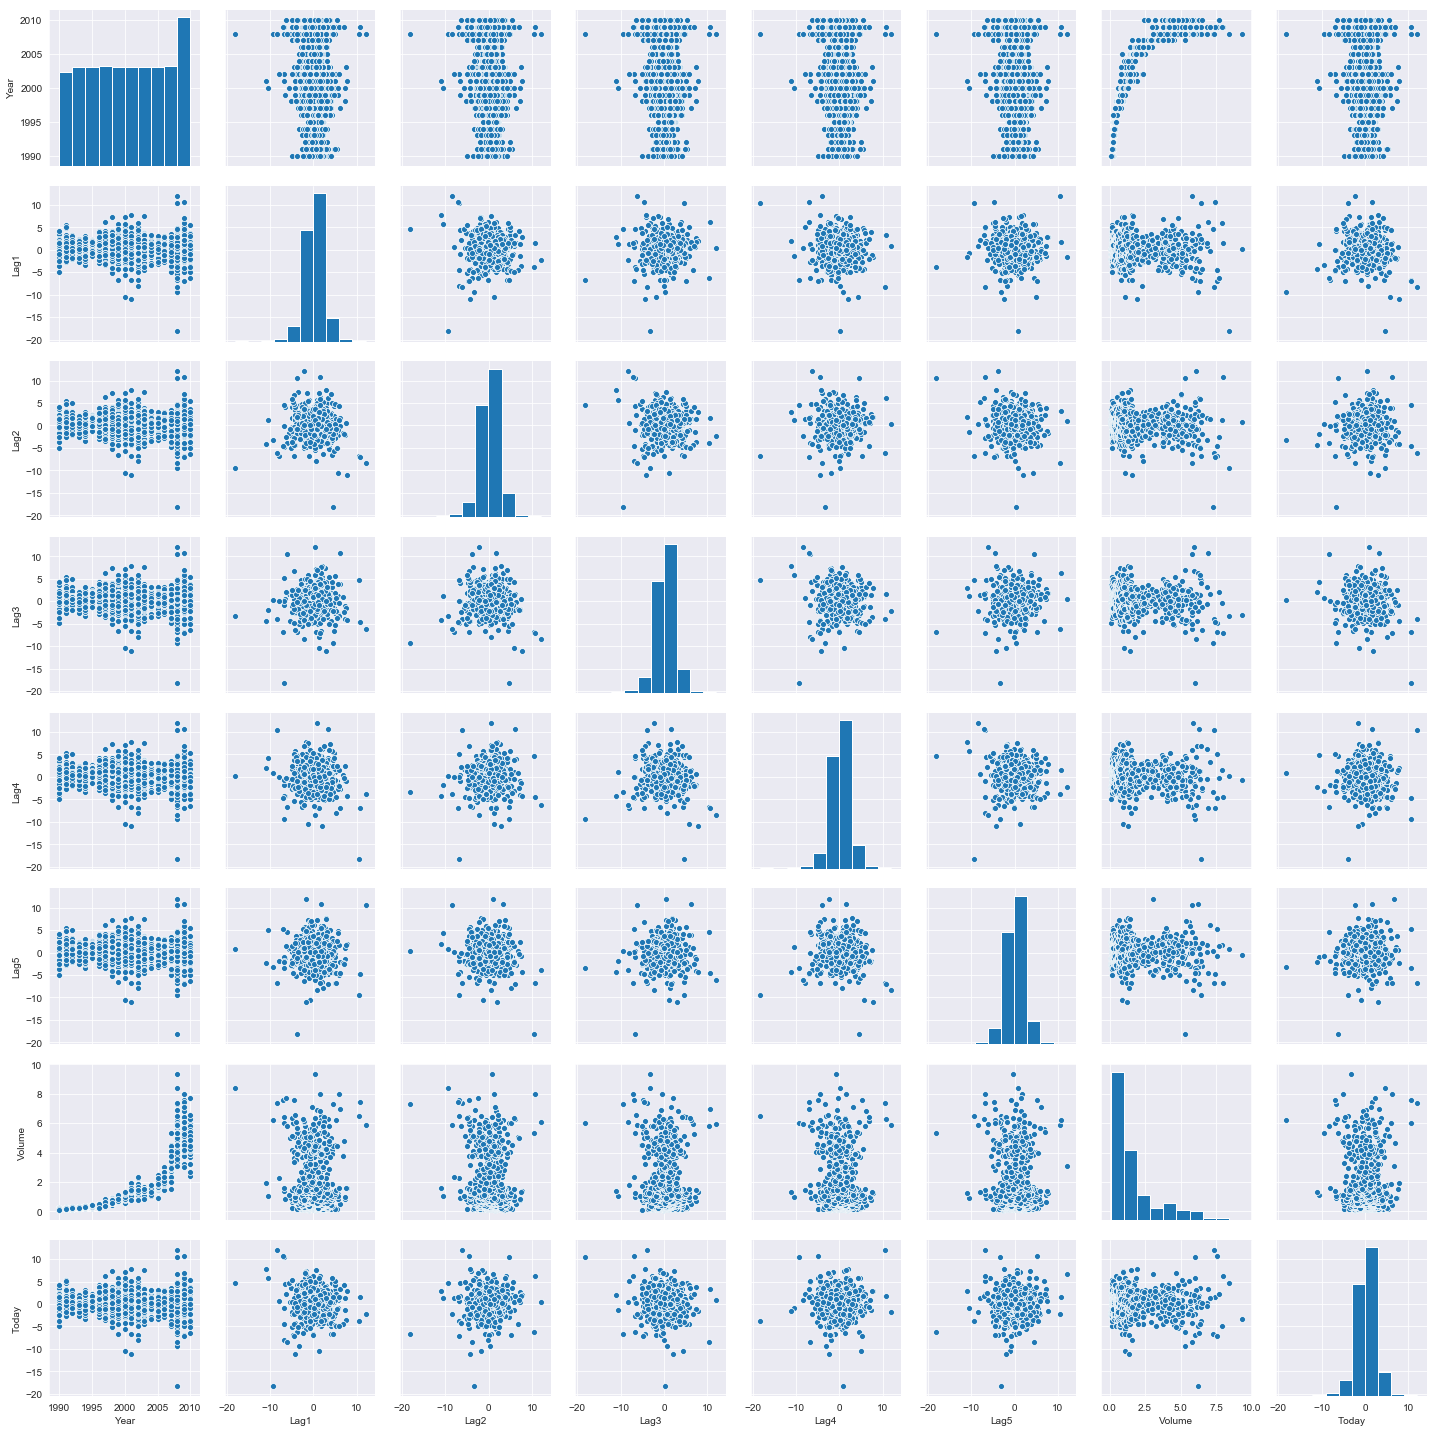

In [194]:
#sns.pairplot(weekly)

#### b)

In [196]:
weekly = pd.get_dummies(weekly, drop_first=True)
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,1
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,1
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,1
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,1


In [237]:
X = weekly.drop(['Direction_Up', 'Today', 'Year'], axis=1)
y = weekly['Direction_Up']
mod = Logit(y, sm.add_constant(X)).fit()
mod.summary()
# Lag2 is the only significant predictor according to this model

Optimization terminated successfully.
         Current function value: 1.925080
         Iterations 4


C:\Users\Taha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Taha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Taha\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                     inf
Time:                        18:33:15   Log-Likelihood:                -2096.4
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

#### c)

In [238]:
y_pred = mod.predict(sm.add_constant(X))

def target(y):
    if y > 0.5:
        return 1
    else:
        return 0
y_pred = y_pred.apply(target)

log_cfm = pd.DataFrame(confusion_matrix(y_pred, y), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
log_cfm

,Pred Down,Pred Up
Actual Down,54,48
Actual Up,430,557


In [244]:
print('Logistic Regression Results', f'\nAccuary: {np.mean(y_pred == y):.4f}', 
      f'\nRecall: {recall_score(y_pred, y):.4f}', f'\nPrecision: {precision_score(y_pred, y):.4f}')
# These results tell us the Accurary of the model is low and only a little better than chance
# The Recall score indicates that out of the values that were actually listed as 'Up' our model only predicted 56% of them
# The Precision indicates that out of the values the model predicted as 'Up', 92% of them are correctly predicted

Logistic Regression Results 
Accuary: 0.5611 
Recall: 0.5643 
Precision: 0.9207


#### d)

In [296]:
X_train, y_train = weekly[weekly['Year'] <2009][['Lag2']], weekly[weekly['Year'] <2009]['Direction_Up']
X_test, y_test = weekly[weekly['Year'] >= 2009][['Lag2']], weekly[weekly['Year'] >= 2009]['Direction_Up']
mod = Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.888927
         Iterations 4


In [297]:
y_pred = mod.predict(sm.add_constant(X_test))

def target(y):
    if y > 0.5:
        return 1
    else:
        return 0
y_pred = y_pred.apply(target)

log_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
log_cfm

,Pred Down,Pred Up
Actual Down,9,5
Actual Up,34,56


In [298]:
print('Logistic Regression Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')

Logistic Regression Results 
Accuary: 0.6250 
Recall: 0.6222 
Precision: 0.9180


#### e)

In [299]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [300]:
y_pred = lda.predict(X_test)
lda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
lda_cfm

,Pred Down,Pred Up
Actual Down,9,5
Actual Up,34,56


In [301]:
print('Linear Discriminant Analysis Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')

Linear Discriminant Analysis Results 
Accuary: 0.6250 
Recall: 0.6222 
Precision: 0.9180


#### f)

In [302]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [303]:
y_pred = qda.predict(X_test)
qda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
qda_cfm

,Pred Down,Pred Up
Actual Down,0,0
Actual Up,43,61


In [253]:
print('Quadratic Discriminant Analysis Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')

Quadratic Discriminant Analysis Results 
Accuary: 0.5865 
Recall: 0.5865 
Precision: 1.0000


#### g)

In [254]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [255]:
y_pred = knn.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
knn_cfm

,Pred Down,Pred Up
Actual Down,21,30
Actual Up,22,31


In [256]:
print('K Nearest Neighbors (K=1) Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')

K Nearest Neighbors (K=1) Results 
Accuary: 0.5000 
Recall: 0.5849 
Precision: 0.5082


#### h)

In [257]:
# From the 4 models, logistic regression and LDA perform best on the data with a 62.5% accurary, high precision at 91%, and decent recall score at 62% 

#### i)

In [258]:
# We will try the following models: KNN with K=10, logistic with interactions, LDA with every predictor, and QDA with polynomial predictors

In [266]:
knn = KNeighborsClassifier(n_neighbors=10)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)
knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
knn_cfm

,Pred Down,Pred Up
Actual Down,22,24
Actual Up,21,37


In [268]:
print('K Nearest Neighbors (K=10) Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')
# Every metric improves with K = 10

K Nearest Neighbors (K=10) Results 
Accuary: 0.5673 
Recall: 0.6379 
Precision: 0.6066


In [275]:
y_train, X_train = dmatrices('Direction_Up ~ Lag1 + Lag2 + Lag1:Lag2', data=weekly[weekly['Year'] < 2009])
y_test, X_test = dmatrices('Direction_Up ~ Lag1 + Lag2 + Lag1:Lag2', data=weekly[weekly['Year'] >= 2009])
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)
log_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
log_cfm

C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Pred Down,Pred Up
Actual Down,7,8
Actual Up,36,53


In [276]:
print('Logistic Regression with Lag1:Lag2 Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')
# This model performs poorly in comparison to the original fit

Logistic Regression with Lag1:Lag2 Results 
Accuary: 0.5616 
Recall: 0.5955 
Precision: 0.8689


In [285]:
X_train, y_train = weekly[weekly['Year'] <2009].drop('Direction_Up', axis=1), weekly[weekly['Year'] <2009]['Direction_Up']
X_test, y_test = weekly[weekly['Year'] >= 2009].drop('Direction_Up', axis=1), weekly[weekly['Year'] >= 2009]['Direction_Up']
lda = LinearDiscriminantAnalysis()
mod = lda.fit(X_train, y_train)
y_pred = mod.predict(X_test)
lda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
lda_cfm

,Pred Down,Pred Up
Actual Down,36,0
Actual Up,7,61


In [286]:
print('LDA with every predictor Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')
# Best performance seen so far with a high accurary, recall, and 100% precision

LDA with every predictor Results 
Accuary: 0.9327 
Recall: 0.8971 
Precision: 1.0000


In [305]:
y_train, X_train = dmatrices('Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + np.power(Lag2, 2) + np.power(Lag2, 3)', data=weekly[weekly['Year'] < 2009])
y_test, X_test = dmatrices('Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + np.power(Lag2, 2) + np.power(Lag2, 3)', data=weekly[weekly['Year'] >= 2009])
qda = QuadraticDiscriminantAnalysis()
mod = qda.fit(X_train, y_train)
y_pred = mod.predict(X_test)
qda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test), index=['Actual Down', 'Actual Up'], columns=['Pred Down', 'Pred Up'])
qda_cfm

C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


,Pred Down,Pred Up
Actual Down,43,61
Actual Up,0,0


In [306]:
print('QDA with polynomial predictors Results', f'\nAccuary: {np.mean(y_pred == y_test):.4f}', 
      f'\nRecall: {recall_score(y_pred, y_test):.4f}', f'\nPrecision: {precision_score(y_pred, y_test):.4f}')
# Worst performance we have seen for predicting the 'Up' class

QDA with polynomial predictors Results 
Accuary: 0.4135 
Recall: 0.0000 
Precision: 0.0000


C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [307]:
# From these 4 models and the previous models we see that the LDA model with all the predictors performed the best on the data

#### 11)
#### a)

In [321]:
auto = pd.read_csv('Auto.csv')
auto.drop(auto.loc[auto['horsepower'] == '?'].index, inplace=True) 
auto['horsepower'] = pd.to_numeric(auto['horsepower'])
auto.drop('name', axis=1, inplace=True)

In [360]:
def mpg(df):
    if df['mpg'] > np.median(auto['mpg']):
        return 1
    else:
        return 0
auto['mpg01'] = auto.apply(mpg, axis=1)

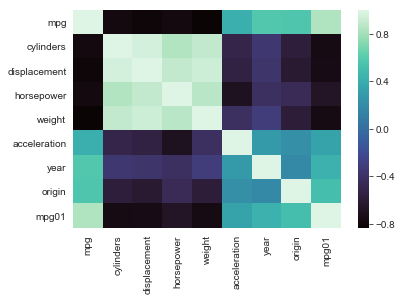

In [362]:
sns.heatmap(auto.corr(), cmap='mako')

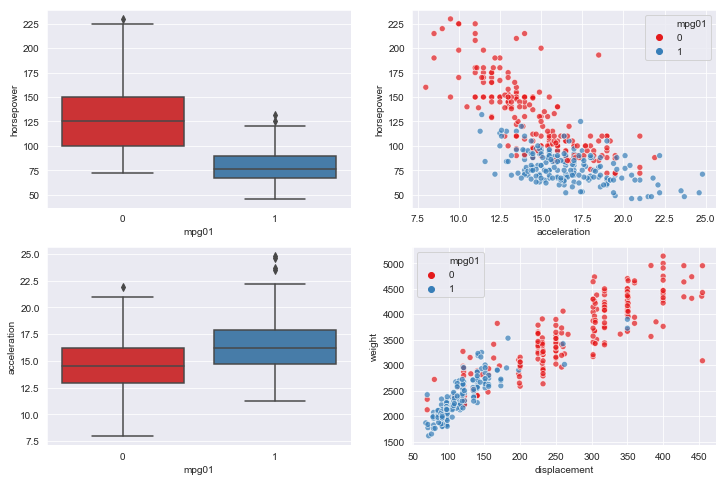

In [383]:
f, ax = plt.subplots(2, 2, figsize=(12,8))

sns.boxplot(x=auto['mpg01'], y=auto['horsepower'], ax=ax[0,0], palette='Set1')
sns.scatterplot(x=auto['acceleration'], y=auto['horsepower'], hue=auto['mpg01'], ax=ax[0,1], palette='Set1', alpha=0.7)
sns.boxplot(x=auto['mpg01'], y=auto['acceleration'], ax=ax[1,0], palette='Set1')
sns.scatterplot(x=auto['displacement'], y=auto['weight'], hue=auto['mpg01'], ax=ax[1,1], palette='Set1', alpha=0.7)
# From these plots we will use the columns cylinders, displacement, horsepower, weight, and acceleration to predict mpg01

#### c)

In [384]:
X = auto.drop(['mpg01', 'mpg', 'year', 'origin'], axis=1)
y = auto['mpg01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### d)

In [404]:
lda = LinearDiscriminantAnalysis()
mod = lda.fit(X_train, y_train)
y_pred = mod.predict(X_test)

lda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(lda_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  57   6
1   7  48
Test error: 11.02%


#### e)

In [405]:
qda = QuadraticDiscriminantAnalysis()
mod = qda.fit(X_train, y_train)
y_pred = mod.predict(X_test)

qda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(qda_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  61   6
1   3  48
Test error: 7.63%


#### f)

In [406]:
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)

log_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(log_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  58   9
1   6  45
Test error: 12.71%


C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [407]:
knn = KNeighborsClassifier(n_neighbors=1)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  53  12
1  11  42
Test error: 19.49%


In [408]:
knn = KNeighborsClassifier(n_neighbors=3)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  53   9
1  11  45
Test error: 16.95%


In [409]:
knn = KNeighborsClassifier(n_neighbors=10)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  56  10
1   8  44
Test error: 15.25%


In [416]:
knn = KNeighborsClassifier(n_neighbors=50)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')
# K = 50 seems to perform the best on the data

    0   1
0  53   4
1  11  50
Test error: 12.71%


#### 12)
#### a)

In [418]:
def power():
    return 2**3
power()

8


#### b)

In [429]:
def power2(x,a):
    return x**a
power2(3,8)

6561

#### c)

In [439]:
print('10**3:', power2(10,3))
print('8**17:', power2(8,17))
print('131**2:', power2(131,2))

10**3: 1000
8**17: 2251799813685248
131**2: 17161


#### d)

In [440]:
def power3(x,a):
    result = x**a
    return result

#### e)

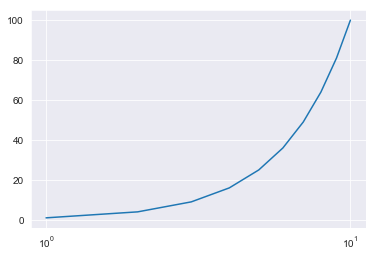

In [466]:
x = np.arange(1,11)
y = power3(x,2)

plt.plot(x,y)
plt.xscale('log')
#plt.yscale('log')
# You can play around with changing the x or y axis to a log scale and see how the plot changes

#### f)

In [471]:
def plotpower(array, power):
    x = array
    y = power3(x,power)
    plt.plot(x,y)

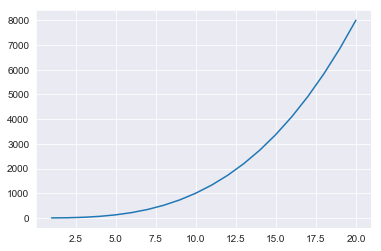

In [473]:
plotpower(np.arange(1,21), 3)

#### 13)

In [474]:
boston = datasets.load_boston()
bos = pd.DataFrame(boston.data, columns=boston.feature_names)
bos['MEDV'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [475]:
def crim(df):
    if df['CRIM'] > np.median(bos['CRIM']):
        return 1
    else:
        return 0
bos['CRIM01'] = bos.apply(crim,axis=1)

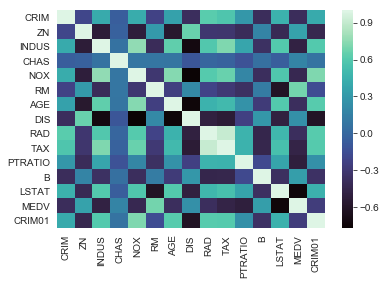

In [478]:
sns.heatmap(bos.corr(), cmap='mako')

In [492]:
X = bos.drop(['CRIM', 'CRIM01'], axis=1)
y = bos['CRIM01']
logit = Logit(y, sm.add_constant(X)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.209414
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 CRIM01   No. Observations:                  506
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                           13
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.6979
Time:                        15:14:09   Log-Likelihood:                -105.96
converged:                       True   LL-Null:                       -350.73
Covariance Type:            nonrobust   LLR p-value:                 2.438e-96
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.1037      6.530     -5.223      0.000     -46.902     -21.305
ZN            -0.0799      0.034     -2.369      0.018      -0.146      -0.014
INDUS         -0.0594      0.044     -1.358      0.174      -0.145       0.026
CHAS           0.7853      0.729      1.077      0.281      -0.643       2.214
NOX           48.5238      7.397      6.560      0.000      34.027      63.021
RM            -0.4256      0.701     -0.607      0.544      -1.800       0.949
AGE            0.0222      0.012      1.814      0.070      -0.002       0.046
DIS            0.6914      0.218      3.167      0.002       0.264       1.119
RAD            0.6565      0.152      4.306      0.000       0.358       0.955
TAX           -0.0064      0.003     -2.385      0.017      -0.012      -0.001
PTRATIO        0.3687      0.122      3.019      0.003       0.129       0.608
B             -0.0135      0.007     -2.069      0.039      -0.026      -0.001
LSTAT          0.0439      0.049      0.895      0.371      -0.052       0.140
MEDV           0.1671      0.067      2.497      0.013       0.036       0.298
==============================================================================

Possibly complete quasi-separation: A fraction 0.37 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [495]:
X = bos.drop(['CRIM', 'CRIM01', 'INDUS', 'CHAS', 'RM', 'AGE', 'B'], axis=1)
y = bos['CRIM01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)

log_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(log_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  90  20
1   8  85
Test error: 13.79%


C:\Users\Taha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [501]:
X = bos.drop(['CRIM', 'CRIM01', 'INDUS', 'CHAS', 'RM', 'AGE', 'B'], axis=1)
y = bos['CRIM01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lda = LinearDiscriminantAnalysis()
mod = lda.fit(X_train, y_train)
y_pred = mod.predict(X_test)

lda_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(lda_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  96  29
1   2  76
Test error: 15.27%


In [502]:
X = bos.drop(['CRIM', 'CRIM01', 'INDUS', 'CHAS', 'RM', 'AGE', 'B'], axis=1)
y = bos['CRIM01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
knn = KNeighborsClassifier(n_neighbors=1)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0    1
0  92    5
1   6  100
Test error: 5.42%


In [510]:
X = bos.drop(['CRIM', 'CRIM01', 'INDUS', 'CHAS', 'RM', 'AGE', 'B'], axis=1)
y = bos['CRIM01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
knn = KNeighborsClassifier(n_neighbors=3)
mod = knn.fit(X_train, y_train)
y_pred = mod.predict(X_test)

knn_cfm = pd.DataFrame(confusion_matrix(y_pred, y_test))
print(knn_cfm)
print(f'Test error: {np.mean(y_pred != y_test):.2%}')

    0   1
0  96   7
1   2  98
Test error: 4.43%


In [ ]:
# After looking at the full model with Logistic Regression and removing the predictors with low P-values and those that could cause collinearity 
# We fit Logistic Regression, LDA, KNN (K=1), and KNN (K=3) with the remaining predictors
# From the test errors of those models we see that the KNN models performed best and K=3 classifiers yields the lowest error rate